# 1. Entendimiento del problema

Monthly expenditure on cafes, restaurants and takeaway food services in Victoria
(Australia) from April 1982 up to April 2024.

# 2. Enfoque Analítico

Vamos a construir un modelo de regresión basado en series de tiempo que permita estimar el costo de corticoides y esteroides con el menor MAE posible.


# 3. Requerimiento de Datos

Se requieren los datos pasados del costo de los medicamentos.

# 4. Recolección de datos

In [2356]:
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
import pandas as pd
import numpy as np


In [2357]:
data = fetch_dataset(name = "expenditures_australia")
data.index.name = 'datetime'

╭───────────────────────────── expenditures_australia ─────────────────────────────╮
│ Description:                                                                     │
│ Monthly expenditure on cafes, restaurants and takeaway food services in Victoria │
│ (Australia) from April 1982 up to April 2024.                                    │
│                                                                                  │
│ Source:                                                                          │
│ Australian Bureau of Statistics. Catalogue No. 8501.0                            │
│ https://www.abs.gov.au/statistics/industry/retail-and-wholesale-trade/retail-    │
│ trade-australia/apr-2024/8501011.xlsx                                            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/refs/heads/main/data/expenditures_australia.csv                         │
│                                                                                  │
│ Shape: 505 rows x 1 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

In [2358]:
data

,turnover
datetime,
1982-04-01,85.1
1982-05-01,85.1
1982-06-01,82.8
1982-07-01,82.1
1982-08-01,81.8
...,...
2023-12-01,1508.8
2024-01-01,1358.3
2024-02-01,1294.8


# 5. Exploracion de datos

* Identificar los patrones estacionales de la serie
* Determinar la estacinoalidad de la serie

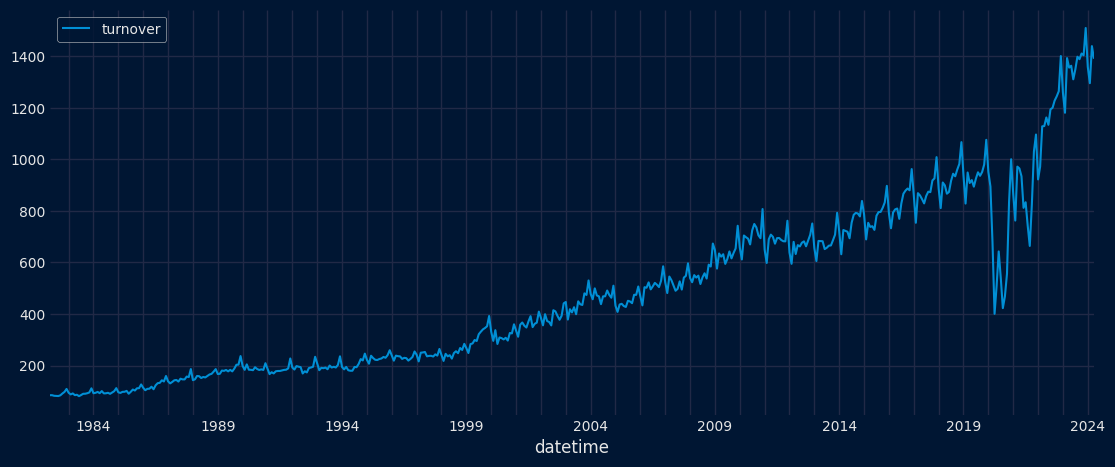

In [2359]:
from skforecast.plot import set_dark_theme
set_dark_theme()

fig, ax = plt.subplots(figsize = (12, 5))
data.plot(ax = ax)
ax.legend()
plt.show()

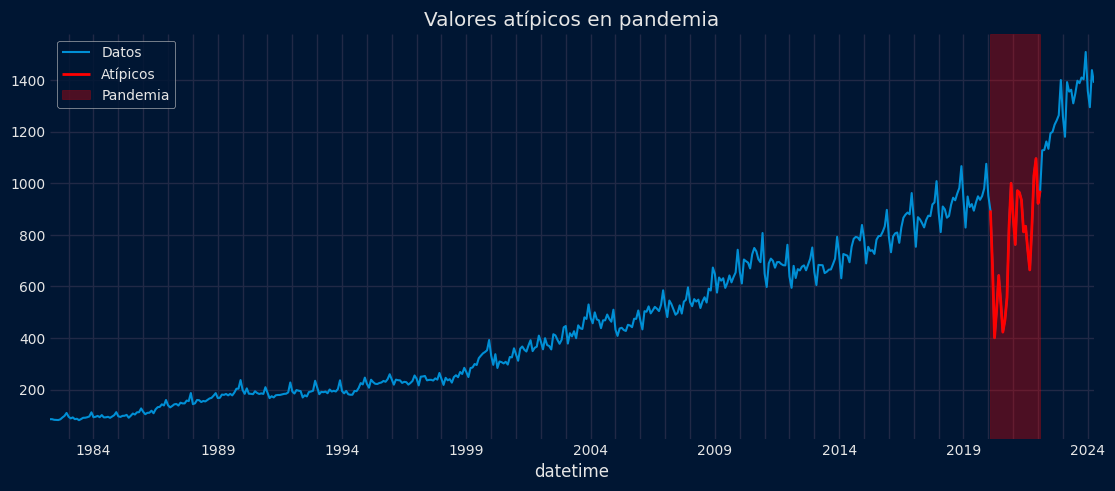

25 datos entre 2020-02-01 y 2022-02-01


In [2360]:
corrupted_start = '2020-02-01'
corrupted_end = '2022-02-01'

corrupted_mask = (data.index >= corrupted_start) & (data.index <= corrupted_end)

corrupted_data = data[corrupted_mask]

plt.figure(figsize=(12, 5))
data['turnover'].plot(label='Datos')
corrupted_data['turnover'].plot(label='Atípicos', color='red', linewidth=2)
plt.axvspan(pd.to_datetime(corrupted_start), pd.to_datetime(corrupted_end), 
           alpha=0.3, color='red', label='Pandemia')
plt.legend()
plt.title('Valores atípicos en pandemia')
plt.show()

print(f"{len(corrupted_data)} datos entre {corrupted_start} y {corrupted_end}")

# Modelo Prepandemia

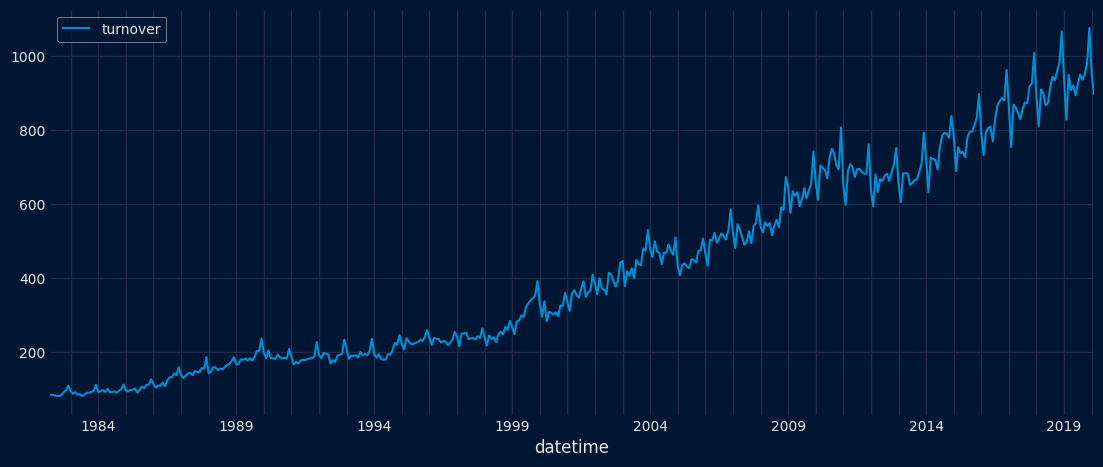

In [2361]:
data_pre_pandemic = data.loc[:corrupted_start]

fig, ax = plt.subplots(figsize = (12, 5))
data_pre_pandemic.plot(ax = ax)
ax.legend()
plt.show()

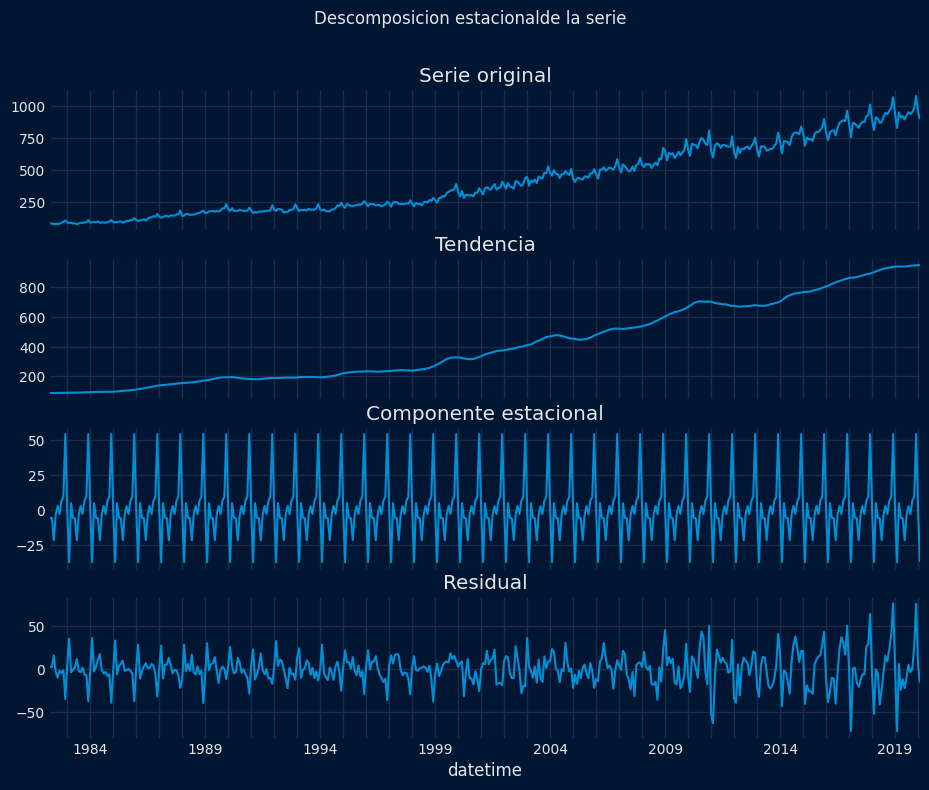

In [2362]:
from statsmodels.tsa.seasonal import seasonal_decompose

res_decompose = seasonal_decompose(data_pre_pandemic['turnover'], model = 'additive', extrapolate_trend = 'freq')
fig, ax = plt.subplots(4, 1, figsize = (10, 8), sharex = True)

res_decompose.observed.plot(ax = ax[0])
ax[0].set_title('Serie original')

res_decompose.trend.plot(ax = ax[1])
ax[1].set_title('Tendencia')

res_decompose.seasonal.plot(ax = ax[2])
ax[2].set_title('Componente estacional')

res_decompose.resid.plot(ax = ax[3])
ax[3].set_title('Residual')

fig.suptitle('Descomposicion estacionalde la serie')
plt.show()

In [2363]:
from statsmodels.tsa.stattools import adfuller

print("Test de Estacionariedad")
adfuller_result = adfuller(data_pre_pandemic['turnover'])
print("ADF Estadístico < 0, p-valor < 0.05")
print(f'ADF Estadístico: {adfuller_result[0]}, p-valor: {adfuller_result[1]}')

Test de Estacionariedad
ADF Estadístico < 0, p-valor < 0.05
ADF Estadístico: 2.0036467237826736, p-valor: 0.9986776710228942


In [2364]:
data_pre_pandemic['turnover']

datetime
1982-04-01      85.1
1982-05-01      85.1
1982-06-01      82.8
1982-07-01      82.1
1982-08-01      81.8
               ...  
2019-10-01     950.4
2019-11-01     979.6
2019-12-01    1075.2
2020-01-01     951.5
2020-02-01     894.6
Freq: MS, Name: turnover, Length: 455, dtype: float64

In [2365]:
data_pre_pandemic['turnover'] = np.log(data_pre_pandemic['turnover'])

print("Test de Estacionariedad")
adfuller_result = adfuller(data_pre_pandemic['turnover'])
print(f'ADF Estadístico: {adfuller_result[0]}, p-valor: {adfuller_result[1]}')

Test de Estacionariedad
ADF Estadístico: -1.5731197085347135, p-valor: 0.4970807448204615


/var/folders/qf/v3r8n0nj7r15zhks6n329mj80000gn/T/ipykernel_91155/1994922748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pre_pandemic['turnover'] = np.log(data_pre_pandemic['turnover'])


In [2366]:
data_pre_pandemic['turnover']

datetime
1982-04-01    4.443827
1982-05-01    4.443827
1982-06-01    4.416428
1982-07-01    4.407938
1982-08-01    4.404277
                ...   
2019-10-01    6.856883
2019-11-01    6.887144
2019-12-01    6.980262
2020-01-01    6.858040
2020-02-01    6.796377
Freq: MS, Name: turnover, Length: 455, dtype: float64

Test de Estacionariedad
ADF Estadístico: -6.060451932651021, p-valor: 1.2161665139835544e-07


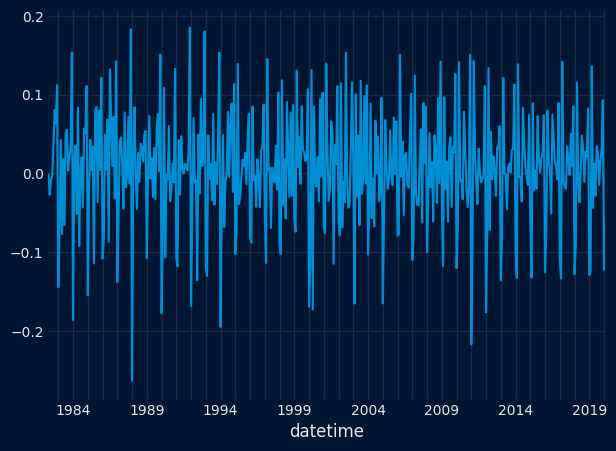

In [2367]:
data_diff = data_pre_pandemic['turnover'].diff().dropna()

print("Test de Estacionariedad")
adfuller_result = adfuller(data_diff)
print(f'ADF Estadístico: {adfuller_result[0]}, p-valor: {adfuller_result[1]}')

data_diff.plot()
plt.show()

In [2368]:
d = 1

Text(0.5, 1.0, 'Autocorrelacion de la serie diferenciada')

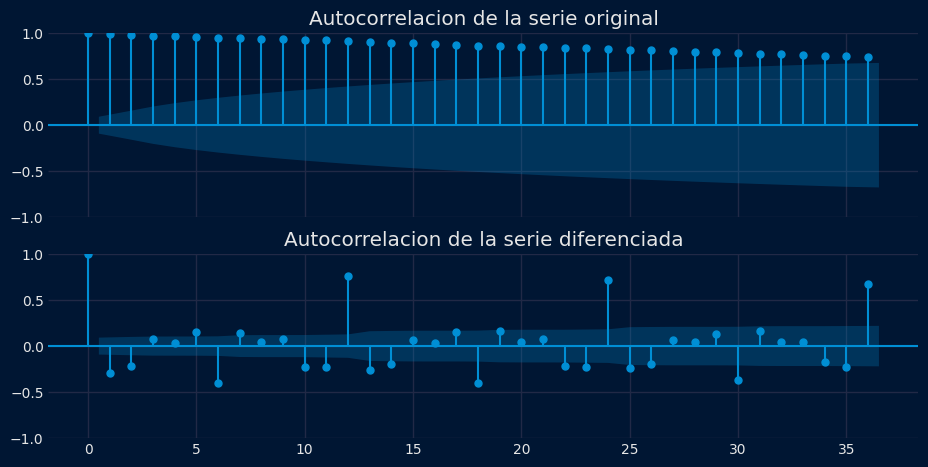

In [2369]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lags = 36   

fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

plot_acf(data_pre_pandemic['turnover'], ax = ax[0], lags = lags, alpha = 0.05)
ax[0].set_title('Autocorrelacion de la serie original')

plot_acf(data_diff, ax = ax[1], lags = lags, alpha = 0.05)
ax[1].set_title('Autocorrelacion de la serie diferenciada')

Existe periodicidad y se puede observar una tendencia decreciente en la autocorrelacion de la serie original, por lo que próximamente diferenciaremos la serie estacionaria


In [2370]:
q = 2
M = 12

Text(0.5, 1.0, 'Autocorrelacion parcial de la serie diferenciada')

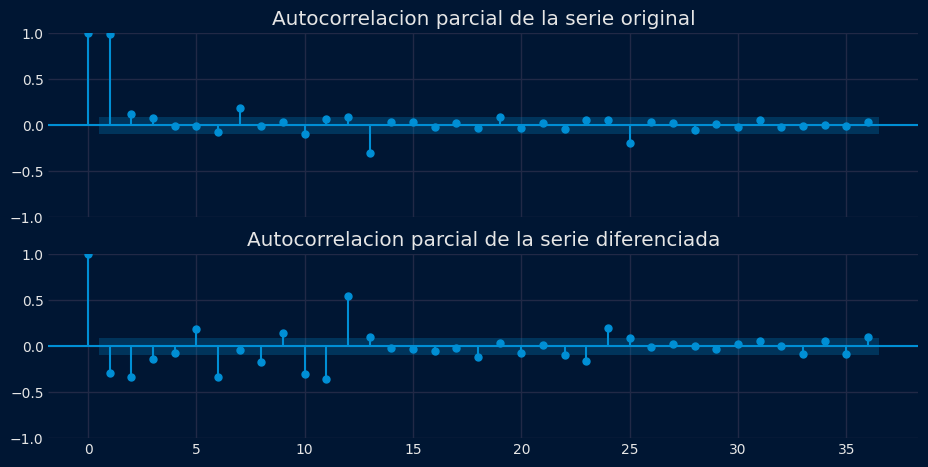

In [2371]:
fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

plot_pacf(data_pre_pandemic['turnover'], ax = ax[0], lags = lags, alpha = 0.05)
ax[0].set_title('Autocorrelacion parcial de la serie original')

plot_pacf(data_diff, ax = ax[1], lags = lags, alpha = 0.05)
ax[1].set_title('Autocorrelacion parcial de la serie diferenciada')

In [2372]:
p = 3

## Diferenciación de la serie estacionaria

In [2373]:
data_diff_12 = data_diff.diff(12).dropna()
adfuller_result = adfuller(data_diff_12)
print(f'ADF Estadístico: {adfuller_result[0]}, p-valor: {adfuller_result[1]}')

ADF Estadístico: -9.265735742585823, p-valor: 1.368610492270028e-15


Text(0.5, 1.0, 'Autocorrelacion parcial estacionalidad')

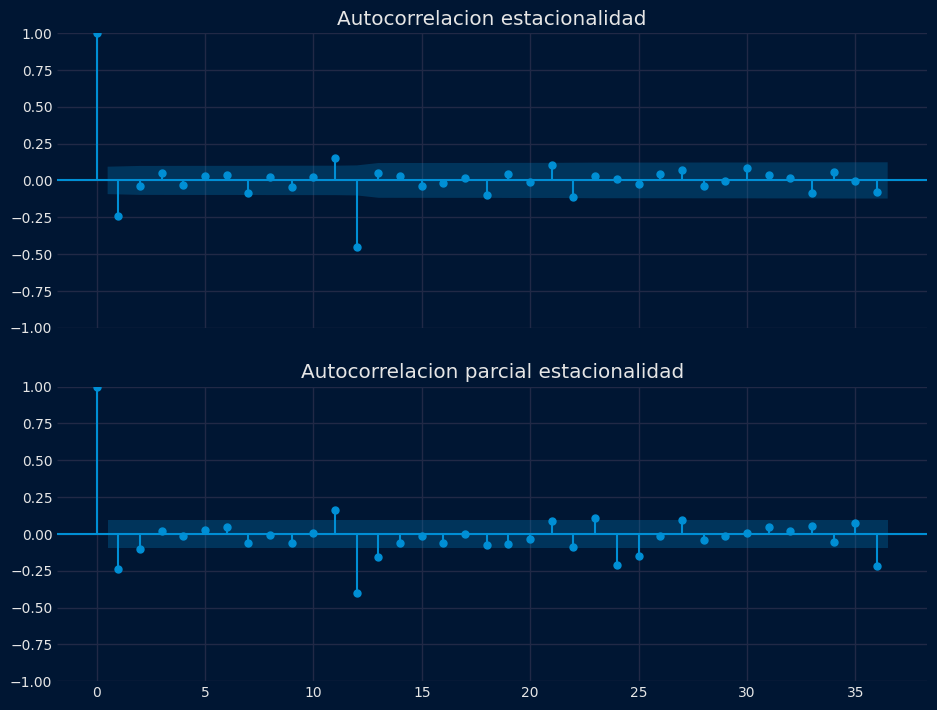

In [2374]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8), sharex = True)

plot_acf(data_diff_12, ax = ax[0], lags = lags, alpha = 0.05)
ax[0].set_title('Autocorrelacion estacionalidad')

plot_pacf(data_diff_12, ax = ax[1], lags = lags, alpha = 0.05)
ax[1].set_title('Autocorrelacion parcial estacionalidad')

In [2375]:
Q = 1
P = 2
D = 1

### Modelado PrePandemia

/Users/alejandro/Documents/Computacion Cientifica/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alejandro/Documents/Computacion Cientifica/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alejandro/Documents/Computacion Cientifica/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


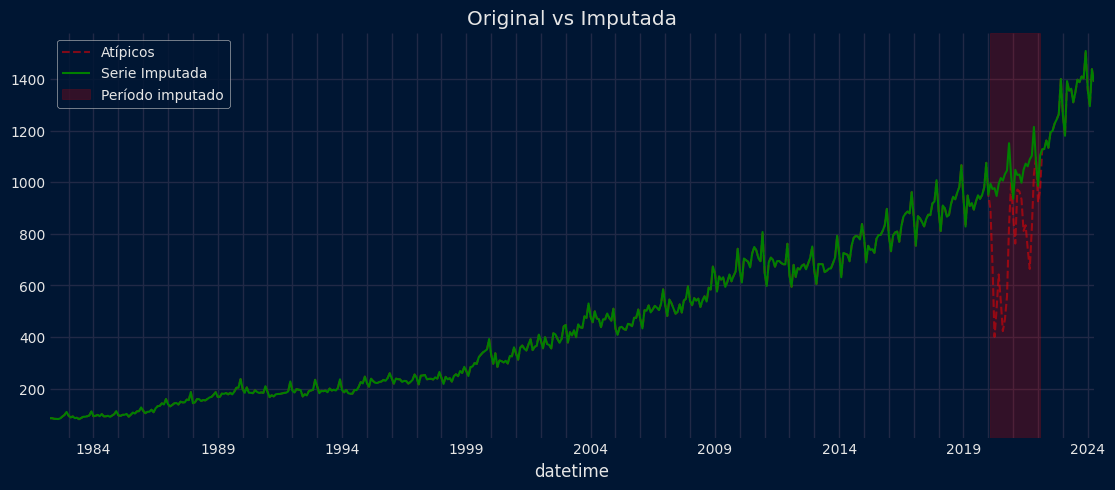

In [2376]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

data_pre_only = data_pre_pandemic.loc[:corrupted_start, 'turnover']
modelo_pre = SARIMAX(
    endog=data_pre_only, 
    order=(p, d, q), 
    seasonal_order=(P, D, Q, M)
)
modelo_pre_fit = modelo_pre.fit(disp=0)

pred_corrupted = modelo_pre_fit.get_forecast(steps=len(corrupted_data)).predicted_mean

data_imputed = data.copy()
data_imputed.loc[corrupted_data.index, 'turnover'] = np.exp(pred_corrupted.values)

# Visualización de la nueva serie reconstruida
plt.figure(figsize = (12, 5))
data['turnover'].plot(label='Atípicos', alpha=0.5, style='--', color='red')
data_imputed['turnover'].plot(label='Serie Imputada', color='green')
plt.axvspan(pd.to_datetime(corrupted_start), pd.to_datetime(corrupted_end), 
           alpha=0.2, color='red', label='Período imputado')
plt.legend()
plt.title('Original vs Imputada')
plt.show()



# Modelo Imputado

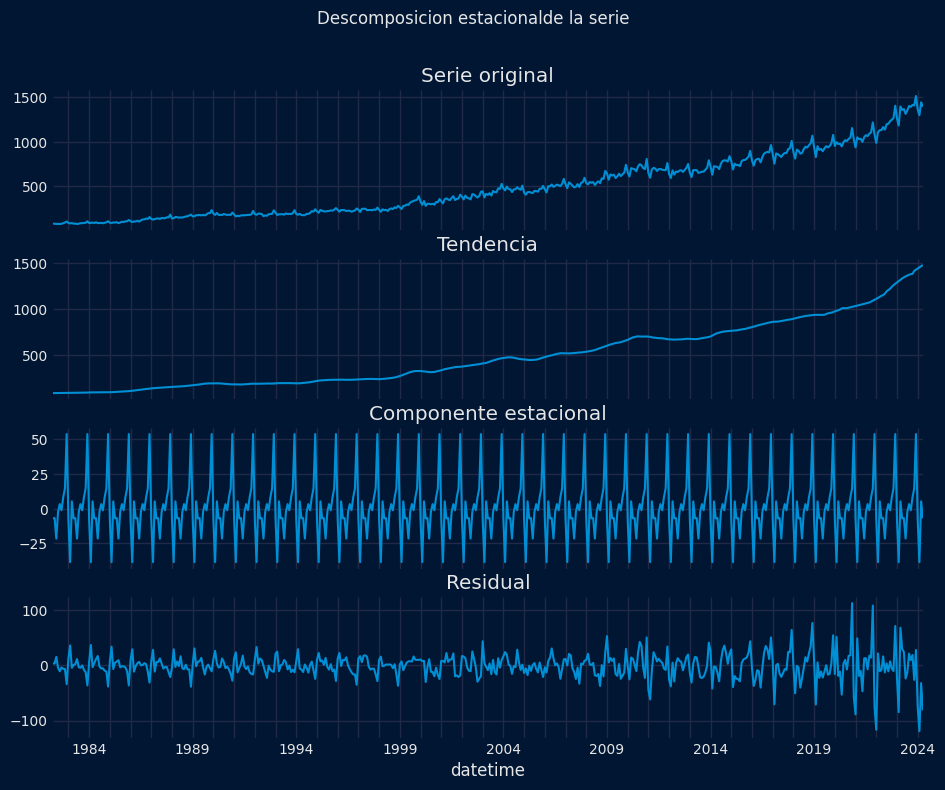

In [2377]:
from statsmodels.tsa.seasonal import seasonal_decompose

res_decompose = seasonal_decompose(data_imputed['turnover'], model = 'additive', extrapolate_trend = 'freq')
fig, ax = plt.subplots(4, 1, figsize = (10, 8), sharex = True)

res_decompose.observed.plot(ax = ax[0])
ax[0].set_title('Serie original')

res_decompose.trend.plot(ax = ax[1])
ax[1].set_title('Tendencia')

res_decompose.seasonal.plot(ax = ax[2])
ax[2].set_title('Componente estacional')

res_decompose.resid.plot(ax = ax[3])
ax[3].set_title('Residual')

fig.suptitle('Descomposicion estacionalde la serie')
plt.show()

In [2378]:
from statsmodels.tsa.stattools import adfuller

print("Test de Estacionariedad")
adfuller_result = adfuller(data_imputed['turnover'])
print("ADF Estadístico < 0, p-valor < 0.05")
print(f'ADF Estadístico: {adfuller_result[0]}, p-valor: {adfuller_result[1]}')

Test de Estacionariedad
ADF Estadístico < 0, p-valor < 0.05
ADF Estadístico: 2.764069613643445, p-valor: 1.0


In [2379]:
data_imputed['turnover']

datetime
1982-04-01      85.1
1982-05-01      85.1
1982-06-01      82.8
1982-07-01      82.1
1982-08-01      81.8
               ...  
2023-12-01    1508.8
2024-01-01    1358.3
2024-02-01    1294.8
2024-03-01    1438.5
2024-04-01    1389.5
Freq: MS, Name: turnover, Length: 505, dtype: float64

In [2380]:
data_imputed['turnover'] = np.log(data_imputed['turnover'])

print("Test de Estacionariedad")
adfuller_result = adfuller(data_imputed['turnover'])
print(f'ADF Estadístico: {adfuller_result[0]}, p-valor: {adfuller_result[1]}')

Test de Estacionariedad
ADF Estadístico: -1.0905436324098856, p-valor: 0.7188282247212066


In [2381]:
data_imputed['turnover']

datetime
1982-04-01    4.443827
1982-05-01    4.443827
1982-06-01    4.416428
1982-07-01    4.407938
1982-08-01    4.404277
                ...   
2023-12-01    7.319070
2024-01-01    7.213989
2024-02-01    7.166112
2024-03-01    7.271356
2024-04-01    7.236699
Freq: MS, Name: turnover, Length: 505, dtype: float64

Test de Estacionariedad
ADF Estadístico: -6.235862695737487, p-valor: 4.8275687666105384e-08


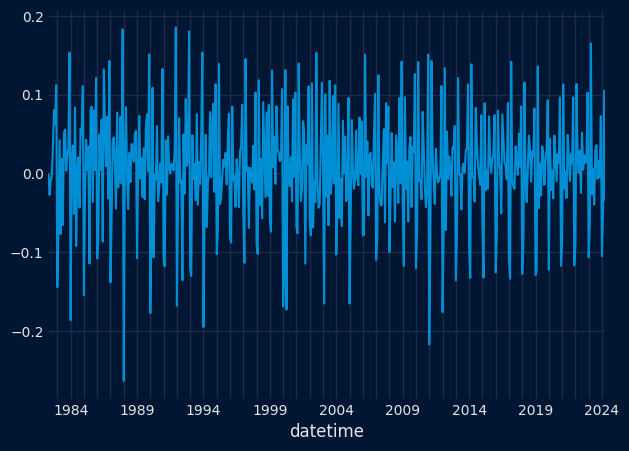

In [2382]:
data_diff = data_imputed['turnover'].diff().dropna()

print("Test de Estacionariedad")
adfuller_result = adfuller(data_diff)
print(f'ADF Estadístico: {adfuller_result[0]}, p-valor: {adfuller_result[1]}')

data_diff.plot()
plt.show()

In [2383]:
d = 1

Text(0.5, 1.0, 'Autocorrelacion de la serie diferenciada')

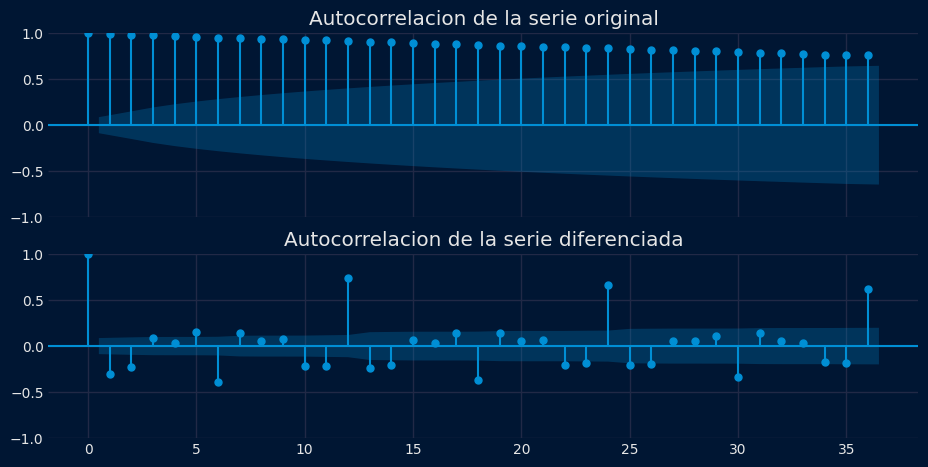

In [2384]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lags = 36   

fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

plot_acf(data_imputed['turnover'], ax = ax[0], lags = lags, alpha = 0.05)
ax[0].set_title('Autocorrelacion de la serie original')

plot_acf(data_diff, ax = ax[1], lags = lags, alpha = 0.05)
ax[1].set_title('Autocorrelacion de la serie diferenciada')

Existe periodicidad y se puede observar una tendencia decreciente en la autocorrelacion de la serie original, por lo que próximamente diferenciaremos la serie estacionaria


In [2385]:
q = 2
M = 12

Text(0.5, 1.0, 'Autocorrelacion parcial de la serie diferenciada')

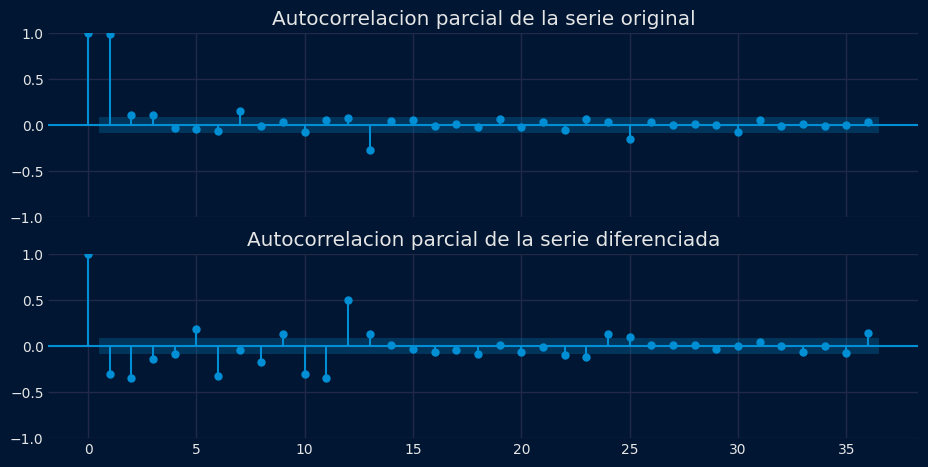

In [2386]:
fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

plot_pacf(data_imputed['turnover'], ax = ax[0], lags = lags, alpha = 0.05)
ax[0].set_title('Autocorrelacion parcial de la serie original')

plot_pacf(data_diff, ax = ax[1], lags = lags, alpha = 0.05)
ax[1].set_title('Autocorrelacion parcial de la serie diferenciada')

In [2387]:
p = 3

## Diferenciación de la serie estacionaria

In [2388]:
data_diff_12 = data_diff.diff(12).dropna()
adfuller_result = adfuller(data_diff_12)
print(f'ADF Estadístico: {adfuller_result[0]}, p-valor: {adfuller_result[1]}')

ADF Estadístico: -9.381056175414137, p-valor: 6.955562217747741e-16


Text(0.5, 1.0, 'Autocorrelacion parcial estacionalidad')

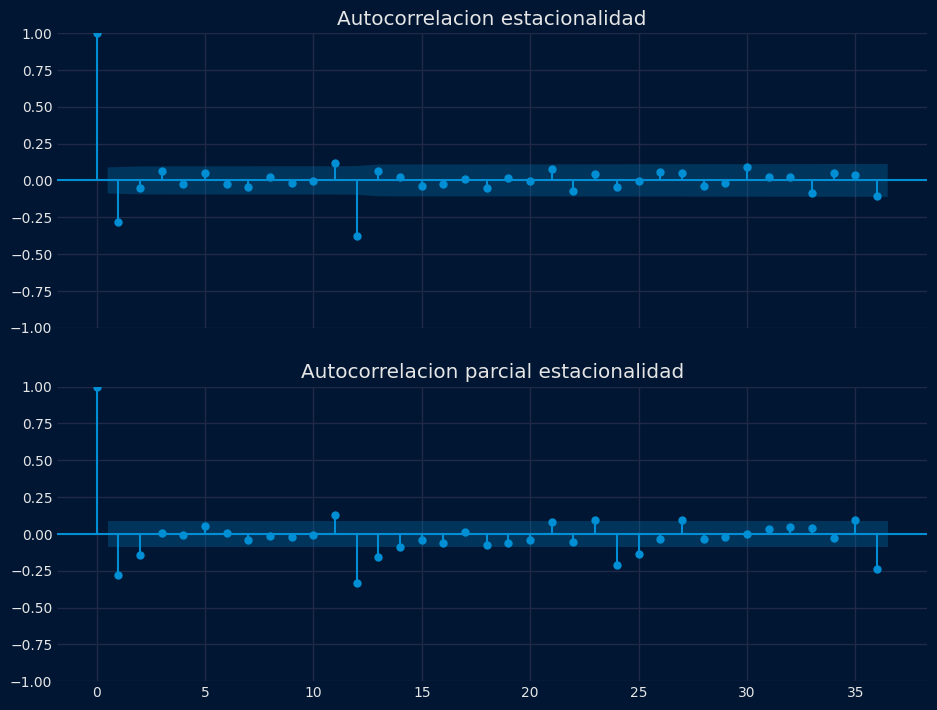

In [2389]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8), sharex = True)

plot_acf(data_diff_12, ax = ax[0], lags = lags, alpha = 0.05)
ax[0].set_title('Autocorrelacion estacionalidad')

plot_pacf(data_diff_12, ax = ax[1], lags = lags, alpha = 0.05)
ax[1].set_title('Autocorrelacion parcial estacionalidad')

In [2390]:
Q = 1
P = 2
D = 1

## Modelado

- SARIMAX
- FOrecaster
- RNA Secuencial

2015-12-01 00:00:00


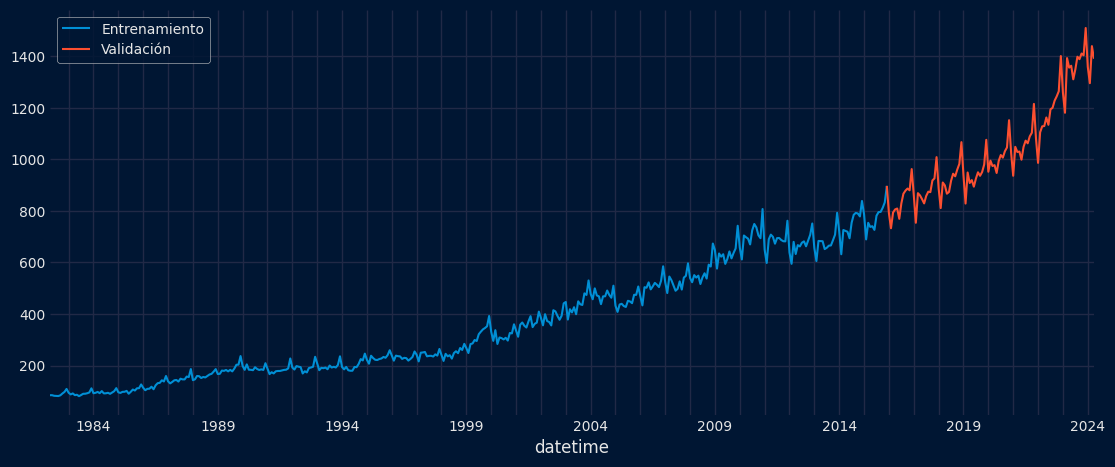

<Figure size 640x480 with 0 Axes>

In [2391]:
train_percentage = 0.80

train_size = int(len(data_imputed) * train_percentage)
end_train = data_imputed.index[train_size]

print(end_train)

data_train = data_imputed['turnover'].loc[:end_train]
data_test = data_imputed['turnover'].loc[end_train:]

plt.figure(figsize = (12, 5))
np.exp(data_train).plot(label = 'Entrenamiento')
np.exp(data_test).plot(label = 'Validación')
plt.legend()
plt.show()

fig.suptitle(f'División {int(train_percentage*100)}/{int((1-train_percentage)*100)}', fontsize=16)
plt.tight_layout()
plt.show()

In [2392]:
p, d, q, P, D, Q, M

(3, 1, 2, 2, 1, 1, 12)

In [2393]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo_sarimax = SARIMAX(endog=data_train, order=(p, d, q), seasonal_order=(P, D, Q, M))
modelo_sarimax = modelo_sarimax.fit(disp=0)

modelo_sarimax.summary()

/Users/alejandro/Documents/Computacion Cientifica/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alejandro/Documents/Computacion Cientifica/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alejandro/Documents/Computacion Cientifica/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             turnover   No. Observations:                  405
Model:             SARIMAX(3, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 717.683
Date:                              Sun, 26 Oct 2025   AIC                          -1417.367
Time:                                      19:35:35   BIC                          -1381.625
Sample:                                  04-01-1982   HQIC                         -1403.201
                                       - 12-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1748      9.922     -0.018      0.986     -19.622      19.273
ar.L2          0.0666      5.125      0.013      0.990      -9.978      10.112
ar.L3          0.0657      1.562      0.042      0.966      -2.996       3.128
ma.L1         -0.1200      9.918     -0.012      0.990     -19.558      19.318
ma.L2         -0.1240      2.225     -0.056      0.956      -4.485       4.237
ar.S.L12       0.0776      0.063      1.231      0.218      -0.046       0.201
ar.S.L24      -0.0025      0.060     -0.042      0.966      -0.120       0.115
ma.S.L12      -0.8922      0.044    -20.256      0.000      -0.978      -0.806
sigma2         0.0014      0.000     14.322      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.43
Prob(Q):                              0.94   Prob(JB):                         0.18
Heteroskedasticity (H):               0.59   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [2394]:
pred_sarimax = modelo_sarimax.get_forecast(steps=len(data_test)).predicted_mean
pred_sarimax.name = 'SARIMAX'

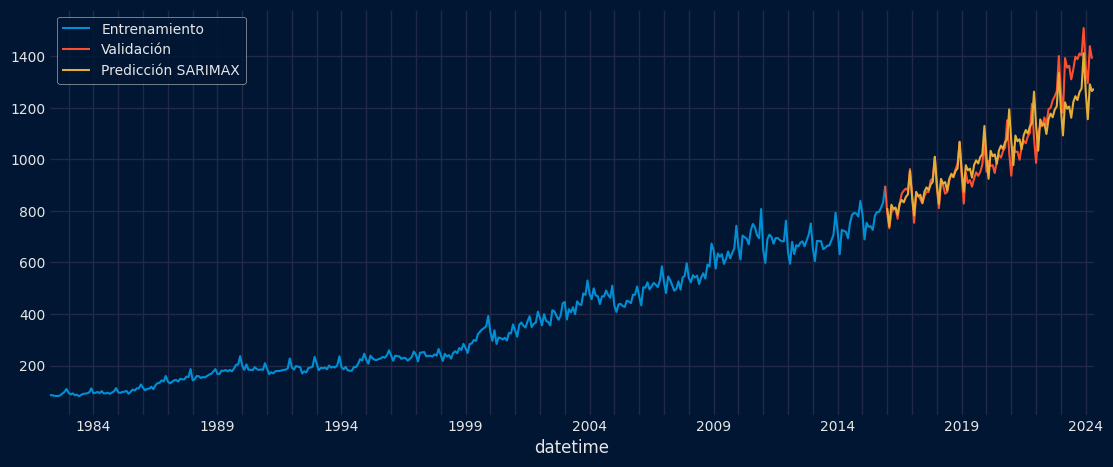

In [2395]:
plt.figure(figsize = (12, 5))
np.exp(data_train).plot(label = 'Entrenamiento')
np.exp(data_test).plot(label = 'Validación')
np.exp(pred_sarimax).plot(label = 'Predicción SARIMAX')
plt.legend()
plt.show()


In [2396]:
from sklearn.metrics import mean_absolute_percentage_error

mape_sarimax = mean_absolute_percentage_error(data_test, pred_sarimax)
print(f'MAPE SARIMAX: {mape_sarimax:.2f}%')

MAPE SARIMAX: 0.01%


### Forecaster 1

In [2397]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.plot import plot_prediction_intervals


In [2416]:
forecaster_1 = ForecasterRecursive(regressor=LinearRegression(),
                                    lags= 15, window_features= RollingFeatures(stats = ['mean'], window_sizes = 10))
forecaster_1.fit(y = data_train, store_in_sample_residuals= True)
forecaster_1

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: ['roll_mean_10'] 
Window size: 15 
Series name: turnover 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1982-04-01 00:00:00'), Timestamp('2015-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False,
    'tol': 1e-06} 
fit_kwargs: {} 
Creation date: 2025-10-26 19:36:26 
Last fit date: 2025-10-26 19:36:26 
Skforecast version: 0.18.0 
Python version: 3.12.11 
Forecaster id: None

In [2417]:
predictions_1 = forecaster_1.predict(steps = len(data_test))

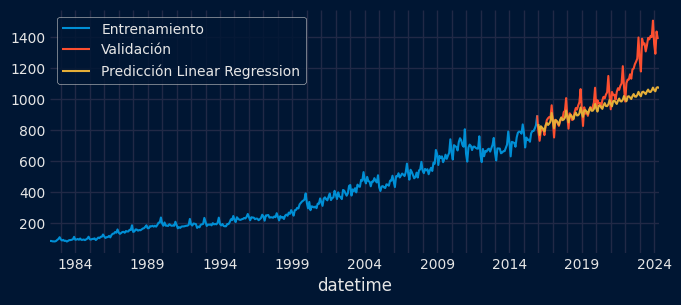

In [ ]:
plt.figure(figsize = (12, 5))
np.exp(data_train).plot(label = 'Entrenamiento')
np.exp(data_test).plot(label = 'Validación')
np.exp(predictions_1).plot(label = 'Predicción Linear Regression')
plt.legend()
plt.show()

In [2422]:
from sklearn.metrics import mean_absolute_percentage_error

mape_predictions_1 = mean_absolute_percentage_error(data_test, predictions_1)
print(f'MAPE Predictions 1: {mape_predictions_1:.2f}%')

MAPE Predictions 1: 0.01%


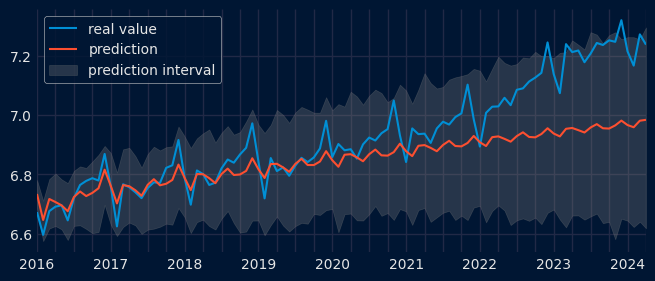

In [2423]:
predictions_1_interval =  forecaster_1.predict_interval(steps = len(data_test) - 1,
                                                        method = 'bootstrapping',
                                                        interval = [5, 95],
                                                        n_boot = 100)
plot_prediction_intervals(predictions_1_interval, data_test, target_variable= 'turnover', 
                        kwargs_fill_between= {'color': 'gray', 'alpha': 0.3})


### Forecaster 2

In [2424]:
forecaster_2 = ForecasterRecursive(regressor=DecisionTreeRegressor(random_state = 42),
                                    lags= 15, window_features= RollingFeatures(stats = ['mean'], window_sizes = 10))
forecaster_2.fit(y = data_train, store_in_sample_residuals= True)
forecaster_2

=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: ['roll_mean_10'] 
Window size: 15 
Series name: turnover 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1982-04-01 00:00:00'), Timestamp('2015-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-10-26 19:37:27 
Last fit date: 2025-10-26 19:37:27 
Skforecast version: 0.18.0 
Python version: 3.12.11 
Forecaster id: None

In [2425]:
predictions_2 = forecaster_2.predict(steps = len(data_test))

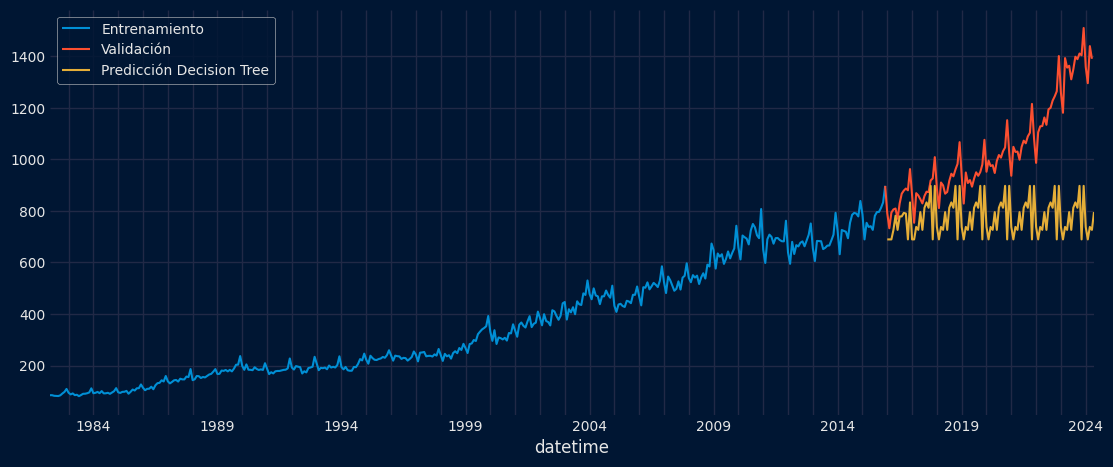

In [2427]:
plt.figure(figsize = (12, 5))
np.exp(data_train).plot(label = 'Entrenamiento')
np.exp(data_test).plot(label = 'Validación')
np.exp(predictions_2).plot(label = 'Predicción Decision Tree')
plt.legend()
plt.show()

In [2428]:
from skforecast.model_selection import grid_search_forecaster, random_search_forecaster, TimeSeriesFold

forecaster_2 = ForecasterRecursive(regressor=DecisionTreeRegressor(random_state = 42), lags = 10)

# Búsqueda de la ventana
lags_grid = { 'lags_1': 3, 'lags_2': 10, 'lags_3': [1, 2, 3, 12]}

# Búsqueda de hiperparámetros del regresor
param_grid = { 'max_depth': [5, 10, 20], 'criterion': ['squared_error', 'poisson', 'absolute_error', 'friedman_mse']}

# Folds
cv = TimeSeriesFold(steps = 12, initial_train_size= len(data_test), refit = False)

# Implementación de la búsqueda
results = grid_search_forecaster(forecaster = forecaster_2, y = data_train, param_grid = param_grid, lags_grid = lags_grid, cv = cv, metric = 'mean_squared_error', return_best = True, n_jobs = -1, verbose = False, show_progress = True)
results


lags grid: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 12] 
  Parameters: {'criterion': 'absolute_error', 'max_depth': 10}
  Backtesting metric: 0.4774626439975992


,lags,lags_label,params,mean_squared_error,criterion,max_depth
0,"[1, 2, 3, 12]",lags_3,"{'criterion': 'absolute_error', 'max_depth': 10}",0.477463,absolute_error,10
1,"[1, 2, 3, 12]",lags_3,"{'criterion': 'absolute_error', 'max_depth': 5}",0.477518,absolute_error,5
2,"[1, 2, 3, 12]",lags_3,"{'criterion': 'absolute_error', 'max_depth': 20}",0.477631,absolute_error,20
3,"[1, 2, 3, 12]",lags_3,"{'criterion': 'friedman_mse', 'max_depth': 20}",0.479195,friedman_mse,20
4,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 20}",0.479195,squared_error,20
5,"[1, 2, 3, 12]",lags_3,"{'criterion': 'poisson', 'max_depth': 10}",0.479218,poisson,10
6,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 10}",0.479227,squared_error,10
7,"[1, 2, 3, 12]",lags_3,"{'criterion': 'friedman_mse', 'max_depth': 10}",0.479227,friedman_mse,10
8,"[1, 2, 3, 12]",lags_3,"{'criterion': 'poisson', 'max_depth': 20}",0.479234,poisson,20
9,"[1, 2, 3, 12]",lags_3,"{'criterion': 'friedman_mse', 'max_depth': 5}",0.479761,friedman_mse,5


In [2429]:
forecaster_2

=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [ 1  2  3 12] 
Window features: None 
Window size: 12 
Series name: turnover 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1982-04-01 00:00:00'), Timestamp('2015-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-10-26 19:38:02 
Last fit date: 2025-10-26 19:38:06 
Skforecast version: 0.18.0 
Python version: 3.12.11 
Forecaster id: None

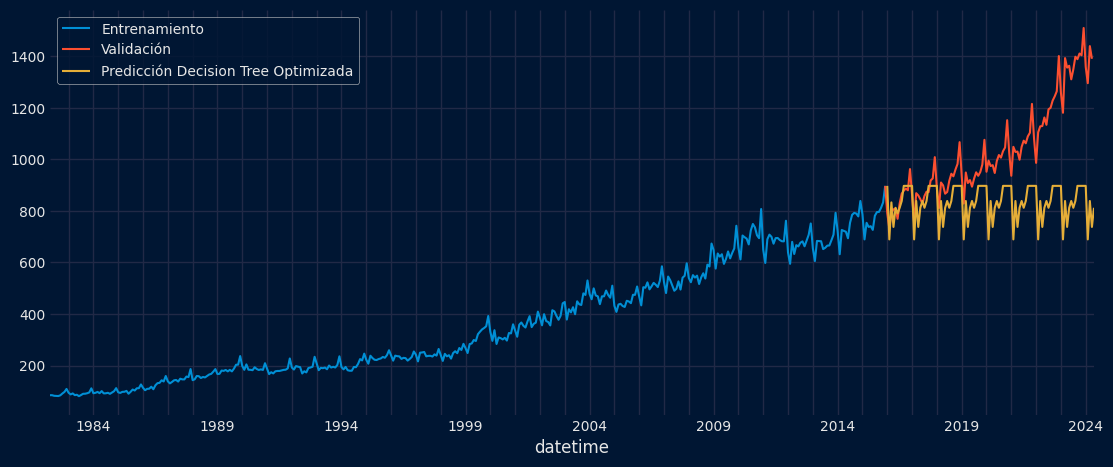

In [2430]:
predictions_2 = forecaster_2.predict(steps = len(data_test))

plt.figure(figsize = (12, 5))
np.exp(data_train).plot(label = 'Entrenamiento')
np.exp(data_test).plot(label = 'Validación')
np.exp(predictions_2).plot(label = 'Predicción Decision Tree Optimizada')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mape_predictions_2 = mean_absolute_percentage_error(data_test, predictions_2)
print(f'MAPE Predictions 2: {mape_predictions_2:.2f}%')

MAPE Predictions 2: 0.04%


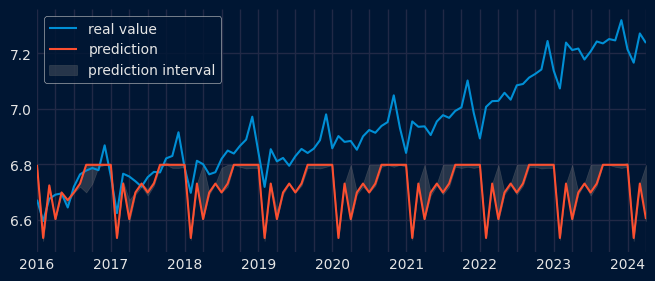

In [2431]:
predictions_2_interval =  forecaster_2.predict_interval(steps = len(data_test) - 1,
                                                        method = 'bootstrapping',
                                                        interval = [5, 95],
                                                        n_boot = 100)
plot_prediction_intervals(predictions_2_interval, data_test, target_variable= 'turnover', 
                        kwargs_fill_between= {'color': 'gray', 'alpha': 0.3})


### Forecaster 3

In [2432]:
from skforecast.model_selection import grid_search_forecaster, random_search_forecaster, TimeSeriesFold

forecaster_3 = ForecasterRecursive(regressor=RandomForestRegressor(random_state = 42), lags = 10)

# Búsqueda de la ventana
lags_grid = { 'lags_1': 3, 'lags_2': 10, 'lags_3': [1, 2, 3, 12]}

# Búsqueda de hiperparámetros del regresor
param_grid = { 'max_depth': [5, 10, 20], 'criterion': ['squared_error', 'poisson', 'absolute_error', 'friedman_mse'], 'n_estimators': [100, 200, 300]}

# Folds
cv = TimeSeriesFold(steps = 12, initial_train_size= len(data_test), refit = False)

# Implementación de la búsqueda
results = grid_search_forecaster(forecaster = forecaster_3, y = data_train, param_grid = param_grid, lags_grid = lags_grid, cv = cv, metric = 'mean_squared_error', return_best = True, n_jobs = -1, verbose = False, show_progress = True)
results


lags grid: 100%|██████████| 3/3 [00:32<00:00, 10.82s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 12] 
  Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 200}
  Backtesting metric: 0.5713130918410972


,lags,lags_label,params,mean_squared_error,criterion,max_depth,n_estimators
0,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 10...",0.571313,squared_error,10,200
1,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 10...",0.572405,squared_error,10,100
2,"[1, 2, 3, 12]",lags_3,"{'criterion': 'poisson', 'max_depth': 10, 'n_e...",0.572925,poisson,10,100
3,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 20...",0.573163,squared_error,20,200
4,"[1, 2, 3, 12]",lags_3,"{'criterion': 'poisson', 'max_depth': 10, 'n_e...",0.573192,poisson,10,200
...,...,...,...,...,...,...,...
103,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'criterion': 'friedman_mse', 'max_depth': 20,...",0.731701,friedman_mse,20,100
104,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'criterion': 'absolute_error', 'max_depth': 2...",0.731816,absolute_error,20,100
105,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'criterion': 'squared_error', 'max_depth': 5,...",0.734299,squared_error,5,100
106,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'criterion': 'absolute_error', 'max_depth': 5...",0.734907,absolute_error,5,100


In [2433]:
forecaster_3

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3 12] 
Window features: None 
Window size: 12 
Series name: turnover 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1982-04-01 00:00:00'), Timestamp('2015-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200,
    'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-10-26 19:39:08 
Last fit date: 2025-10-26 19:39:40 
Skforecast version: 0.18.0 
Python version: 3.12.11 
Forecaster id: None

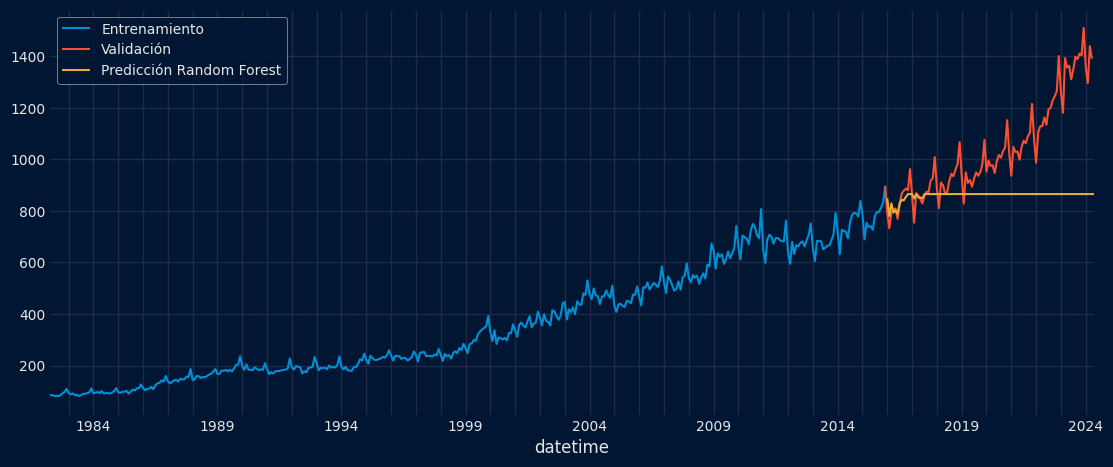

In [2451]:
predictions_3 = forecaster_3.predict(steps = len(data_test))
plt.figure(figsize = (12, 5))
np.exp(data_train).plot(label = 'Entrenamiento')
np.exp(data_test).plot(label = 'Validación')
np.exp(predictions_3).plot(label = 'Predicción Random Forest')
plt.legend()
plt.show()


In [2437]:
from sklearn.metrics import mean_absolute_percentage_error

mape_predictions_3 = mean_absolute_percentage_error(data_test, predictions_3)
print(f'MAPE Predictions 3: {mape_predictions_3:.2f}%')

MAPE Predictions 3: 0.03%


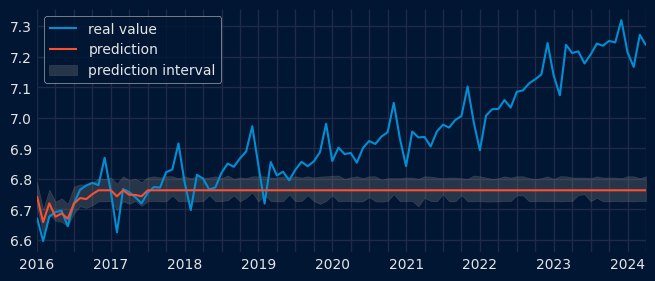

In [2439]:
predictions_3_interval =  forecaster_3.predict_interval(steps = len(data_test) - 1,
                                                        method = 'bootstrapping',
                                                        interval = [5, 95],
                                                        n_boot = 100)
plot_prediction_intervals(predictions_3_interval, data_test, target_variable= 'turnover', 
                        kwargs_fill_between= {'color': 'gray', 'alpha': 0.3})


# Redes Neuronales Artificales

In [2440]:
from skforecast.deep_learning import ForecasterRnn, create_and_compile_model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2441]:
len(data_train)

405

In [2443]:
model_rna = create_and_compile_model(series = pd.DataFrame(data_train), lags = 24, steps = 1,
                                    levels= ['turnover'], recurrent_layer= 'RNN', recurrent_units= 100, dense_units= 64)

model_rna.summary()


keras version: 3.11.3
Using backend: tensorflow
tensorflow version: 2.20.0



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (SimpleRNN)               │ (None, 100)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,729 (65.35 KB)

 Trainable params: 16,729 (65.35 KB)

 Non-trainable params: 0 (0.00 B)

In [2445]:
forecaster_4 = ForecasterRnn(model_rna, lags = 24, levels = ['turnover'],
                            transformer_series= MinMaxScaler(),
                            fit_kwargs= {'epochs': 25, 
                                        'batch_size': 512, 
                                        'callbacks': [EarlyStopping(monitor = 'val_loss', restore_best_weights= True)],
                                        'series_val': pd.DataFrame(data_test),
                                        },
                            )

forecaster_4.fit(pd.DataFrame(data_train))

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 0.2923 - val_loss: 0.2464
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0323 - val_loss: 0.0439
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0304 - val_loss: 0.0156
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0143 - val_loss: 0.0229


In [2446]:
forecaster_4

============= 
ForecasterRnn 
============= 
Regressor: <Functional name=functional, built=True> 
Layers names: ['series_input', 'rnn_1', 'dense_1', 'output_dense_td_layer', 'reshape'] 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Maximum steps to predict: [1] 
Series names: turnover 
Target series (levels): ['turnover'] 
Exogenous included: False 
Exogenous names: None 
Transformer for series: MinMaxScaler() 
Transformer for exog: MinMaxScaler() 
Training range: [Timestamp('1982-04-01 00:00:00'), Timestamp('2015-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'name': 'functional', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 24, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'series_input'}, 'registered_name': None, 'name': 'series_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'SimpleRNN', 'config': {'name': 'rnn_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 100, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 1]}, 'name': 'rnn_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 24, 1), 'dtype': 'float32', 'keras_history': ['series_input', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100]}, 'name': 'dense_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 100), 'dtype': 'float32', 'keras_history': ['rnn_1', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output_dense_td_layer', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}, 'name': 'output_dense_td_layer', 'inbound_nodes': [{'args': ({'c

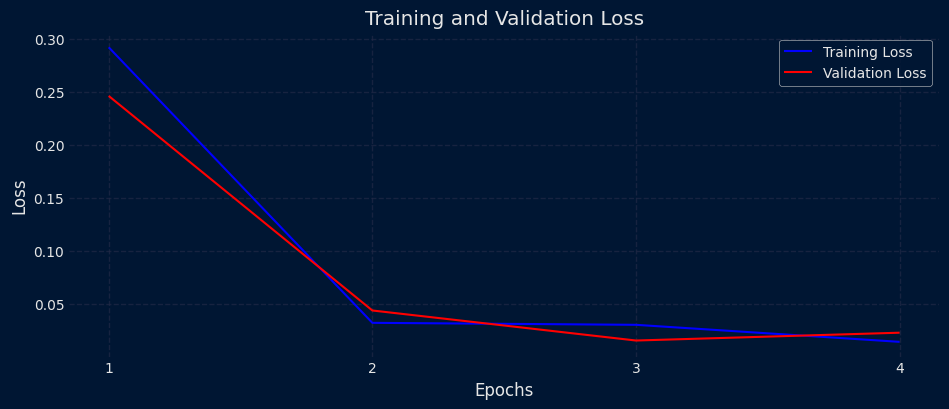

In [2447]:
fig, ax = plt.subplots(figsize = (10, 4))
plot = forecaster_4.plot_history(ax = ax)


In [2448]:
from skforecast.model_selection import backtesting_forecaster_multiseries

cv = TimeSeriesFold(steps = forecaster_4.max_step, initial_train_size= len(data_test), refit = False)

metrics, predictions_4 = backtesting_forecaster_multiseries(forecaster = forecaster_4, series = pd.DataFrame(data_train), cv = cv,
                                                    levels = forecaster_4.levels,
                                                    metric = 'mean_squared_error',
                                                    verbose = False)


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 0.0120 - val_loss: 2.2918
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0052 - val_loss: 2.1282


100%|██████████| 304/304 [00:07<00:00, 41.12it/s]


In [2449]:
predictions_4.pred

1990-09-01    5.140191
1990-10-01    5.164777
1990-11-01    5.194143
1990-12-01    5.168766
1991-01-01    5.174233
                ...   
2015-08-01    5.441259
2015-09-01    5.434351
2015-10-01    5.428823
2015-11-01    5.438375
2015-12-01    5.449422
Name: pred, Length: 304, dtype: float32

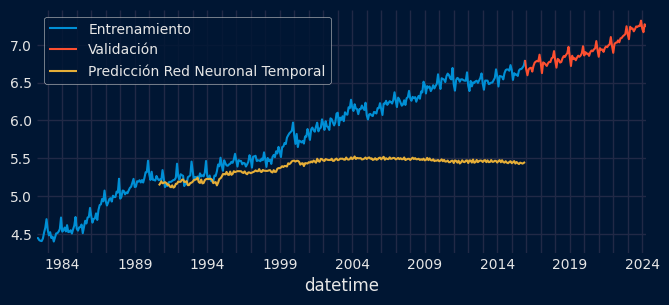

In [2450]:
plt.figure(figsize = (7, 3))
data_train.plot(label = 'Entrenamiento')
data_test.plot(label = 'Validación')
predictions_4.pred.plot(label = 'Predicción Red Neuronal Temporal')
plt.legend()
plt.show()